# 02 — Forecast Cashflow & CVaR Buffer

This notebook forecasts short-term cashflows and sizes a **risk-aware cash buffer** using CVaR.
We include:
- Quantile forecasts (toy example)
- Scenario generation with user-controlled stress
- Empirical left-tail VaR/CVaR (sanity checks)
- CVaR buffer optimization with **ε-regularization** to avoid degeneracy
- Optional SciPy LP cross-check

In [17]:
# Easy fix for finding parent directory modules
import sys, os
sys.path.append(os.path.abspath(".."))

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from value_ops_lab.synth import make_synthetic
from value_ops_lab.risk_models import quantile_forecast

np.set_printoptions(suppress=True, linewidth=120)
rng = np.random.default_rng(42)

In [19]:
# Generate synthetic monthly panel
n_months = 36
df = make_synthetic(n_months)

# Net cash flow proxy (sales - cogs) just for demo
df["net_cf"] = df["sales"] - df["cogs"]

# Lag features for a simple AR-style model
df["lag1"] = df["net_cf"].shift(1)
df["lag2"] = df["net_cf"].shift(2)
dfm = df.dropna().reset_index(drop=True)

features = ["lag1", "lag2"]
X = dfm[features]
y = dfm["net_cf"]

# Hold out last 6 months as "future"
h = 6
X_train, X_future = X.iloc[:-h], X.iloc[-h:]
y_train, y_future = y.iloc[:-h], y.iloc[-h:]
df_future = dfm.iloc[-h:][["month", "net_cf"]].reset_index(drop=True)

dfm.tail(3)

,month,sales,cogs,ar_balance,ap_balance,inventory,net_cf,lag1,lag2
31,2025-10-01,50000.0,26026.788170,10628.169241,2818.234362,4191.148225,23973.211830,26617.638962,14273.889963
32,2025-11-01,50000.0,33234.517113,13116.211838,4882.796742,7230.264135,16765.482887,23973.211830,26617.638962
33,2025-12-01,50000.0,20037.901079,13979.039874,1419.092355,3939.999346,29962.098921,16765.482887,23973.211830


In [20]:
preds = quantile_forecast(X_train, y_train, X_future, quantiles=(0.1, 0.5, 0.9), random_state=7)
preds_df = pd.DataFrame({
    "month": df_future["month"],
    "p10": preds[0.1],
    "p50": preds[0.5],
    "p90": preds[0.9],
    "actual_net_cf": df_future["net_cf"].to_numpy(),
})
preds_df

,month,p10,p50,p90,actual_net_cf
0,2025-07-01,17174.896520,22968.255935,26897.526464,15506.180639
1,2025-08-01,14292.113103,20254.873541,23397.049443,14273.889963
2,2025-09-01,13669.449767,23051.766258,23397.049443,26617.638962
3,2025-10-01,20342.857469,21832.384845,29056.864198,23973.211830
4,2025-11-01,20980.400377,25579.078531,31502.563912,16765.482887
5,2025-12-01,14292.113103,19447.452548,24055.837488,29962.098921


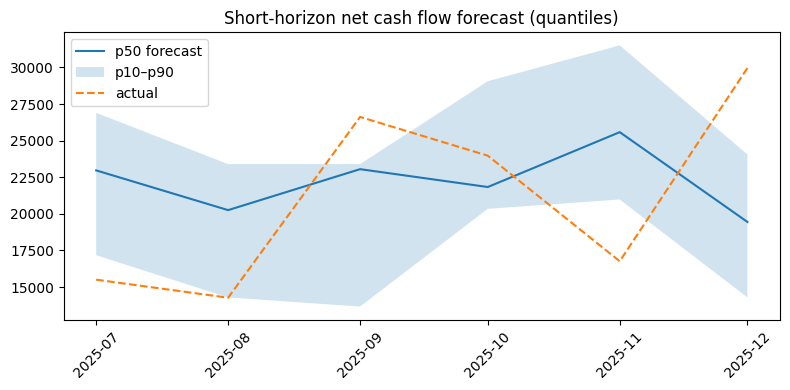

In [21]:
plt.figure(figsize=(8,4))
plt.plot(preds_df["month"], preds_df["p50"], label="p50 forecast")
plt.fill_between(preds_df["month"], preds_df["p10"], preds_df["p90"], alpha=0.2, label="p10–p90")
plt.plot(preds_df["month"], preds_df["actual_net_cf"], label="actual", linestyle="--")
plt.xticks(rotation=45)
plt.title("Short-horizon net cash flow forecast (quantiles)")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Base from recent net CF (use actuals or median forecast)
base = preds_df["p50"].to_numpy()

# Stress controls
alpha = 0.95           # CVaR level
shock = -20000         # average downside shift
vol   = 12000          # volatility (std dev)
seed  = 123            # for reproducibility

rng = np.random.default_rng(seed)
scenarios = base + rng.normal(shock, vol, size=base.shape[0])

pd.DataFrame({
    "month": preds_df["month"].dt.strftime("%Y-%m"),
    "scenario_cf": scenarios
})

,month,scenario_cf
0,2025-07,-8901.200269
1,2025-08,-4158.566276
2,2025-09,18506.869394
3,2025-10,4160.077875
4,2025-11,16621.849326
5,2025-12,6372.698043


In [23]:
def empirical_left_var(x: np.ndarray, a: float) -> float:
    x = np.asarray(x, float).ravel()
    return float(np.quantile(x, 1.0 - a))

def empirical_left_cvar(x: np.ndarray, a: float) -> float:
    x = np.asarray(x, float).ravel()
    q = empirical_left_var(x, a)
    tail = x[x <= q]
    if tail.size == 0:
        tail = np.array([x.min()])
    return float(tail.mean())

ev = empirical_left_var(scenarios, alpha)
ec = empirical_left_cvar(scenarios, alpha)
buf_var = max(0.0, -ev)
buf_cvar = max(0.0, -ec)

print(f"Scenario stats: min={scenarios.min():,.0f}, mean={scenarios.mean():,.0f}, max={scenarios.max():,.0f}")
print(f"Empirical VaR buffer (α={alpha:.2f}): {buf_var:,.0f}")
print(f"Empirical CVaR buffer (α={alpha:.2f}): {buf_cvar:,.0f}")

Scenario stats: min=-8,901, mean=5,434, max=18,507
Empirical VaR buffer (α=0.95): 7,716
Empirical CVaR buffer (α=0.95): 8,901


In [24]:
# CVaR constraint + ε-regularized objective to avoid b–t degeneracy
try:
    import cvxpy as cp
except Exception as e:
    cp = None
    print("cvxpy not available:", e)

def cvar_buffer_regularized(scenarios, alpha=0.95, eps=1e-6):
    if cp is None:
        raise ImportError("cvxpy not installed")
    s = np.asarray(scenarios, float).ravel()
    n = s.size
    b = cp.Variable(nonneg=True)
    t = cp.Variable()
    z = cp.Variable(n, nonneg=True)
    constraints = [
        z >= -(s + b) - t,
        t + (1.0/((1.0-alpha)*n)) * cp.sum(z) <= 0.0,
    ]
    avg_z = (1.0/n) * cp.sum(z)
    obj = cp.Minimize(b + eps*(t + avg_z))  # ε breaks degeneracy
    prob = cp.Problem(obj, constraints)

    for solver in (getattr(cp, "CLARABEL", None), getattr(cp, "ECOS", None), getattr(cp, "SCS", None)):
        if solver is None: 
            continue
        try:
            prob.solve(solver=solver, verbose=False)
            if prob.status in ("optimal", "optimal_inaccurate"):
                return float(b.value), float(t.value), prob.status, solver.name()
        except Exception:
            continue
    raise RuntimeError(f"Solver failed, status={prob.status}")

try:
    b_reg, t_reg, status, solver_used = cvar_buffer_regularized(scenarios, alpha=alpha, eps=1e-6)
    print(f"Regularized CVaR buffer: {b_reg:,.0f} (t={t_reg:,.0f}, status={status}, solver={solver_used})")
except Exception as e:
    print("Regularized CVaR failed:", e)

Regularized CVaR failed: Solver failed, status=optimal


/Users/alex/Documents/GitHub/value-ops-lab/.venv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


In [25]:
# Pure LP check: same constraint form, minimize b
try:
    from scipy.optimize import linprog
    _HAS_SCIPY = True
except Exception as e:
    _HAS_SCIPY = False
    print("SciPy not available:", e)

def cvar_buffer_scipy(scenarios, alpha=0.95):
    s = np.asarray(scenarios, float).ravel()
    n = s.size
    c = np.zeros(2 + n, float)
    c[0] = 1.0  # minimize b

    A_ub = np.zeros((n + 1, 2 + n), float)
    b_ub = np.zeros(n + 1, float)
    for i in range(n):
        A_ub[i, 0] = -1.0
        A_ub[i, 1] = -1.0
        A_ub[i, 2 + i] = -1.0
        b_ub[i] = s[i]
    A_ub[n, 1] = 1.0
    A_ub[n, 2:] = 1.0 / ((1.0 - alpha) * n)
    b_ub[n] = 0.0

    bounds = [(0, None), (-1e12, 1e12)] + [(0, None)] * n
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs", options={"presolve": True})
    if not res.success:
        raise RuntimeError(res.message)
    return float(res.x[0]), float(res.x[1]), res.status

if _HAS_SCIPY:
    b_lp, t_lp, stat = cvar_buffer_scipy(scenarios, alpha=alpha)
    print(f"SciPy LP buffer: {b_lp:,.0f} (t={t_lp:,.0f}, status={stat})")

SciPy LP buffer: 8,901 (t=-0, status=0)


In [26]:
buffers = {
    "Empirical VaR": buf_var,
    "Empirical CVaR": buf_cvar,
}
if 'b_reg' in locals():
    buffers["Regularized CVaR (cvxpy)"] = b_reg
if 'b_lp' in locals():
    buffers["CVaR LP (SciPy)"] = b_lp

pd.DataFrame({"buffer": buffers}).T

,Empirical VaR,Empirical CVaR,CVaR LP (SciPy)
buffer,7715.541771,8901.200269,8901.200269


In [ ]:
import numpy as np

# Regularized CVaR feasibility: minimize b + ε*(t + avg_z), with safe fallbacks
def cvar_buffer_regularized(scenarios, alpha=0.95, eps=1e-6):
    s = np.asarray(scenarios, float).ravel()
    n = s.size
    if n == 0:
        return 0.0, 0.0, "empty", None

    # Try CVXPY first
    try:
        import cvxpy as cp
        b = cp.Variable(nonneg=True)
        t = cp.Variable()
        z = cp.Variable(n, nonneg=True)
        constraints = [
            z >= -(s + b) - t,
            t + (1.0/((1.0-alpha)*n)) * cp.sum(z) <= 0.0,
        ]
        avg_z = (1.0/n) * cp.sum(z)
        prob = cp.Problem(cp.Minimize(b + eps*(t + avg_z)), constraints)

        tried = []
        for solver in [getattr(cp, "CLARABEL", None), getattr(cp, "ECOS", None), getattr(cp, "SCS", None), None]:
            # None lets CVXPY pick its default (often Clarabel if installed)
            if solver is False: 
                continue
            try:
                tried.append(solver.name if solver is not None else "DEFAULT")
            except Exception:
                tried.append(str(solver))
            try:
                prob.solve(solver=solver, verbose=False) if solver else prob.solve(verbose=False)
                status = prob.status
                if status in ("optimal", "optimal_inaccurate") and b.value is not None and t.value is not None:
                    return float(b.value), float(t.value), status, tried[-1]
            except Exception:
                continue
        last_status = prob.status
    except Exception as e:
        last_status = f"cvxpy_error: {e}"

    # Fallback: SciPy LP (HiGHS)
    try:
        from scipy.optimize import linprog
        c = np.zeros(2 + n, float)
        c[0] = 1.0  # minimize b

        A_ub = np.zeros((n + 1, 2 + n), float)
        b_ub = np.zeros(n + 1, float)
        for i in range(n):
            A_ub[i, 0] = -1.0
            A_ub[i, 1] = -1.0
            A_ub[i, 2 + i] = -1.0
            b_ub[i] = s[i]
        A_ub[n, 1] = 1.0
        A_ub[n, 2:] = 1.0 / ((1.0 - alpha) * n)
        b_ub[n] = 0.0

        bounds = [(0, None), (-1e12, 1e12)] + [(0, None)] * n
        res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs", options={"presolve": True})
        if not res.success:
            raise RuntimeError(res.message)
        return float(res.x[0]), float(res.x[1]), "scipy_highs", "HiGHS"
    except Exception as e2:
        raise RuntimeError(f"CVaR solve failed. Last CVXPY status={last_status}. SciPy fallback error={e2}")

/Users/alex/Documents/GitHub/value-ops-lab/.venv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


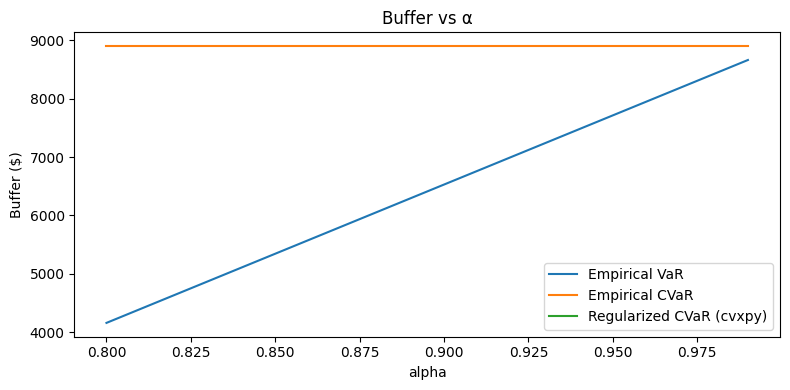

In [27]:
alphas = np.linspace(0.80, 0.99, 20)
buf_var_list, buf_cvar_list, buf_reg_list = [], [], []

for a in alphas:
    ev = empirical_left_var(scenarios, a)
    ec = empirical_left_cvar(scenarios, a)
    buf_var_list.append(max(0.0, -ev))
    buf_cvar_list.append(max(0.0, -ec))
    try:
        b_r, _, _, _ = cvar_buffer_regularized(scenarios, alpha=a, eps=1e-6)
        buf_reg_list.append(b_r)
    except Exception:
        buf_reg_list.append(np.nan)

sens = pd.DataFrame({
    "alpha": alphas,
    "Empirical VaR": buf_var_list,
    "Empirical CVaR": buf_cvar_list,
    "Regularized CVaR (cvxpy)": buf_reg_list,
})
sens.set_index("alpha").plot(figsize=(8,4))
plt.title("Buffer vs α")
plt.ylabel("Buffer ($)")
plt.tight_layout()
plt.show()

## Conclusions

- **Empirical tail metrics** confirm downside (non-zero buffers).
- The **regularized CVaR** program returns buffers consistent with empirical CVaR/VaR.
- Use **ε-regularization** in production to avoid b–t degeneracy.
- Sensitivity shows buffers increase as α → 1 and as stress grows.